In [1]:
import findspark
findspark.init()

In [2]:
import pyspark #only run after findspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.csv('titanic.csv',header=True,sep= ",",inferSchema=True)

df.limit(5).show()

+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+
|Survived|Pclass|                Name|   Sex| Age|Siblings/Spouses Aboard|Parents/Children Aboard|   Fare|
+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+
|       0|     3|Mr. Owen Harris B...|  male|22.0|                      1|                      0|   7.25|
|       1|     1|Mrs. John Bradley...|female|38.0|                      1|                      0|71.2833|
|       1|     3|Miss. Laina Heikk...|female|26.0|                      0|                      0|  7.925|
|       1|     1|Mrs. Jacques Heat...|female|35.0|                      1|                      0|   53.1|
|       0|     3|Mr. William Henry...|  male|35.0|                      0|                      0|   8.05|
+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+



In [4]:
from pyspark.sql.functions import col, isnan, when, count, avg

# Shows null values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

#drops all null values, not needed for this dataset
#df = df.na.drop()

+--------+------+----+---+---+-----------------------+-----------------------+----+
|Survived|Pclass|Name|Sex|Age|Siblings/Spouses Aboard|Parents/Children Aboard|Fare|
+--------+------+----+---+---+-----------------------+-----------------------+----+
|       0|     0|   0|  0|  0|                      0|                      0|   0|
+--------+------+----+---+---+-----------------------+-----------------------+----+



In [5]:
df.groupBy('Survived').count().show()
# 1 represents a survivor, and 0 a casualty

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  545|
+--------+-----+



In [6]:
df.select('Survived','Fare').groupBy('Survived').agg(avg('Fare')).show()

+--------+------------------+
|Survived|         avg(Fare)|
+--------+------------------+
|       1| 48.39540760233917|
|       0|22.208584036697225|
+--------+------------------+



In [7]:
#Need numerical value for correleation matrix

df = df.withColumn('Sex', when(df['Sex']=='male', 0).otherwise(1))

In [8]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Returns pandas correlation matrix, corr_columns allows control of what variables to correlate

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = 'features'
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

In [9]:
corr_columns = ['Survived','Pclass','Sex','Age','Siblings/Spouses Aboard',
'Parents/Children Aboard','Fare']

correlation_matrix(df, corr_columns)

C:\Spark\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
Survived,1.000000,-0.336528,0.542152,-0.059665,-0.037082,0.080097,0.256179
Pclass,-0.336528,1.000000,-0.129507,-0.391492,0.085026,0.020252,-0.548919
Sex,0.542152,-0.129507,1.000000,-0.091875,0.113249,0.244337,0.181137
Age,-0.059665,-0.391492,-0.091875,1.000000,-0.297669,-0.193741,0.112329
Siblings/Spouses Aboard,-0.037082,0.085026,0.113249,-0.297669,1.000000,0.414244,0.158839
Parents/Children Aboard,0.080097,0.020252,0.244337,-0.193741,0.414244,1.000000,0.215470
Fare,0.256179,-0.548919,0.181137,0.112329,0.158839,0.215470,1.000000


In [10]:
# Setup vector column for ML

ignore = ['Survived', 'Name']
mlassembler = VectorAssembler(inputCols=[x for x in df.columns if x not in ignore], outputCol = 'features')
new_df = mlassembler.transform(df).select(['features', 'Survived'])

In [11]:
# Split into training and testing set

train, test = new_df.randomSplit([0.75, 0.25], seed = 1912)
print('Train dataset count:', train.count())
print('Test dataset count:', test.count())

Train dataset count: 681
Test dataset count: 206


In [12]:
# A logistic regression model

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol='Survived')
lr_model = lr.fit(train)

AUC of the LR model: 0.8779390420899845
Accuracy: 73.3 %


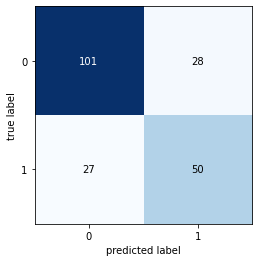

In [13]:
print('AUC of the LR model:', lr_model.summary.areaUnderROC)

# It seems easiest to find accuracy and a confusion matrix w/ sklearn, though this may break with huge datasets?
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

realVSpred = lr_model.transform(test).select('Survived', 'prediction')
realVSprednp = np.array((realVSpred.collect()))

accuracy = accuracy_score(realVSprednp[:,0], realVSprednp[:,1]) # 0 is 'Survived' and 1 is 'prediction'
print(f'Accuracy: {round(accuracy*100,2)} %')

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(realVSprednp[:,0],realVSprednp[:,1])

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [14]:
# A random forest classifier model
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Survived')
rf_model = rf.fit(train)

AUC of the RF model: 0.9218160377358491
Accuracy: 77.18 %


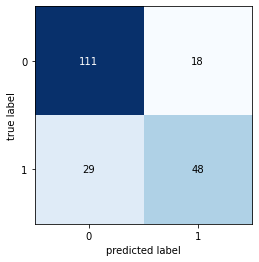

In [15]:
print('AUC of the RF model:', rf_model.summary.areaUnderROC)

rfrealVSpred = rf_model.transform(test).select('Survived', 'prediction')
rfrealVSprednp = np.array((rfrealVSpred.collect()))

rfaccuracy = accuracy_score(rfrealVSprednp[:,0], rfrealVSprednp[:,1]) #0 is 'Survived' and 1 is 'prediction'
print(f'Accuracy: {round(rfaccuracy*100,2)} %')

rfcm = confusion_matrix(rfrealVSprednp[:,0],rfrealVSprednp[:,1])

fig, ax = plot_confusion_matrix(conf_mat=rfcm)
plt.show()